# WQ Mixed-Tile Walkthrough (DeepSeek)

This notebook documents different tensor mixed tile compression algorithms applied to the Deepseek R1 weights. Mixed tile compression algorithms assign each tile of 32x32 values one of the TT block floating point data formats.

In [3]:
from pathlib import Path
import subprocess
import sys

from IPython.display import Image, Markdown, display

repo_root = Path.cwd()
while repo_root != repo_root.parent and not (repo_root / "wq").exists():
    repo_root = repo_root.parent

if not (repo_root / "wq").exists():
    raise FileNotFoundError("Could not locate repo root containing wq")

results_root = repo_root / "results" / "deepseek-ai__DeepSeek-R1"
sweep_root = results_root / "mixed_tile_threshold_sweep"

print(f"Repo root: {repo_root}")
print(f"Results root: {results_root}")


Repo root: /Users/jrock/repos/quantization-plots
Results root: /Users/jrock/repos/quantization-plots/results/deepseek-ai__DeepSeek-R1


## Sweep Mixed-Tile-Threshold (Script)

Algorithm summary:
- Tensor is reshaped/padded to 32x32 tiles.
- For each threshold step, each tile is assigned the lowest-byte format that passes the metric threshold (`pcc >= threshold`, `mae/atol <= threshold`).
- The sweep writes per-tensor CSV detail files and aggregate overlay plots (`weight_overlays.png`, `layer_overlays.png`).

The command below runs `scripts/sweep_mixed_tile_threshold.py` on DeepSeek attention weights, sweeping from best attainable metric down to `--lowest-metric-val`.

This is intentionally a markdown-only cell because full sweeps are long-running.

```bash
python scripts/sweep_mixed_tile_threshold.py deepseek-ai/DeepSeek-R1 \
  'model\.layers\.[0-9]+\.self_attn\..*\.weight$' \
  --lowest-metric-val 0.90 \
  --steps 50 \
  --out-dir results/deepseek-ai__DeepSeek-R1/mixed_tile_threshold_sweep/$(date +%Y%m%d-%H%M%S)_attn
```

## Existing Sweep Overlay Results

Display `layer_overlays.png` and `weight_overlays.png` for each existing run folder under `results/deepseek-ai__DeepSeek-R1/mixed_tile_threshold_sweep`.

**Layer overlays:** data is grouped per layer; each sub-plot shows all weights for a particular layer ID

**Wright overlays:** data is grouped per weight identifier; each sub-plot shows all layers for a partucular weight

Found 4 sweep run folder(s).


### 20260216-212451_experts

Layer overlay

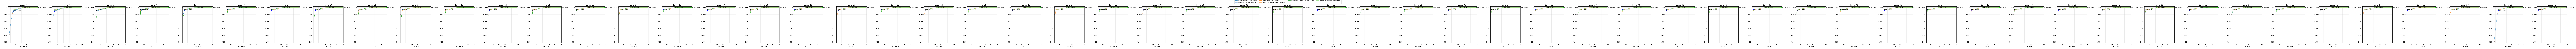

Weight overlay

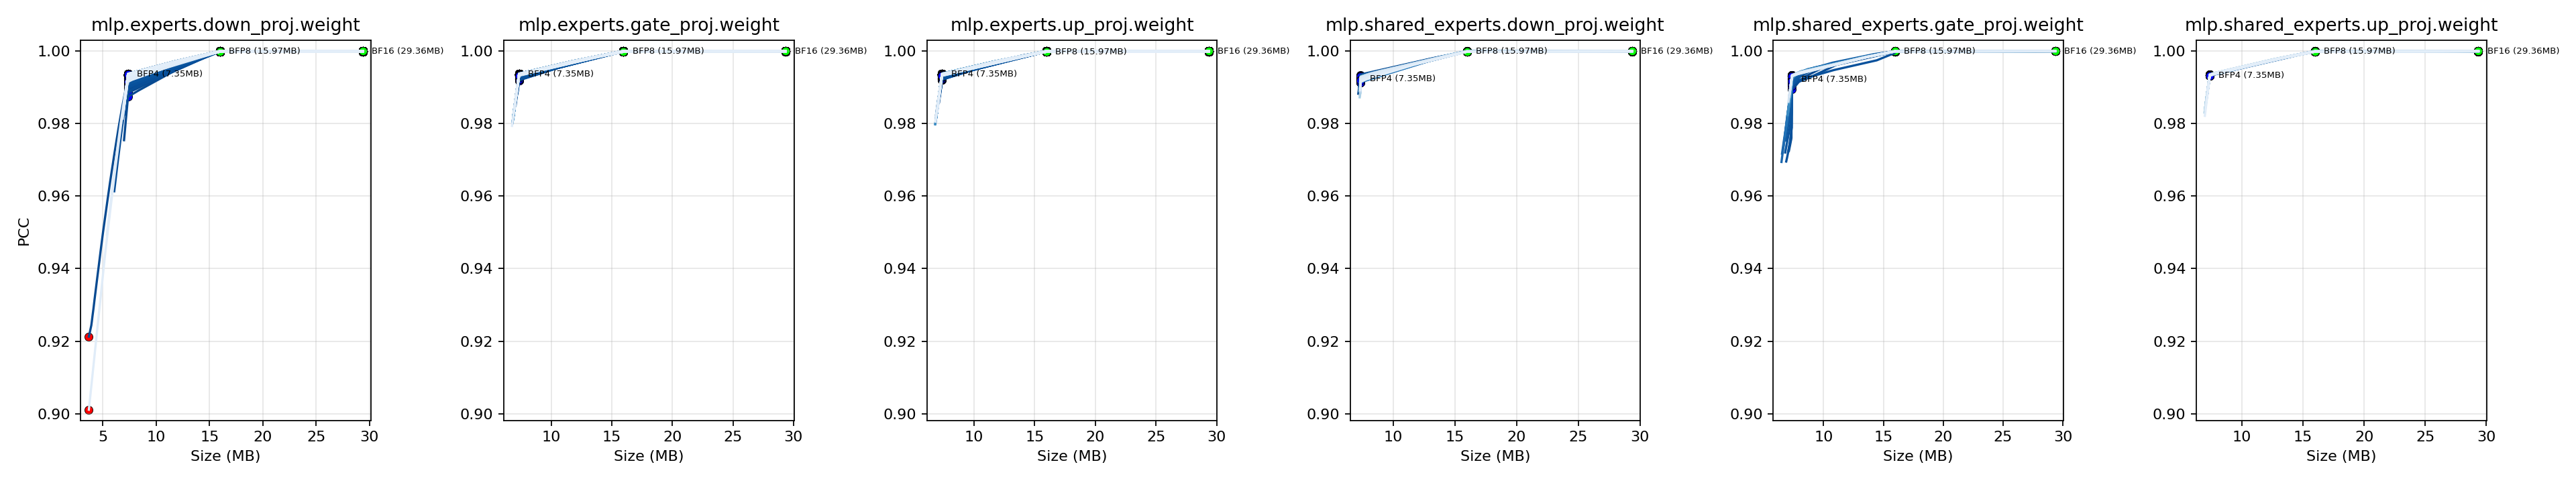

### 20260217-105417_embedding_lmhead

Layer overlay: not available in this run.

Weight overlay

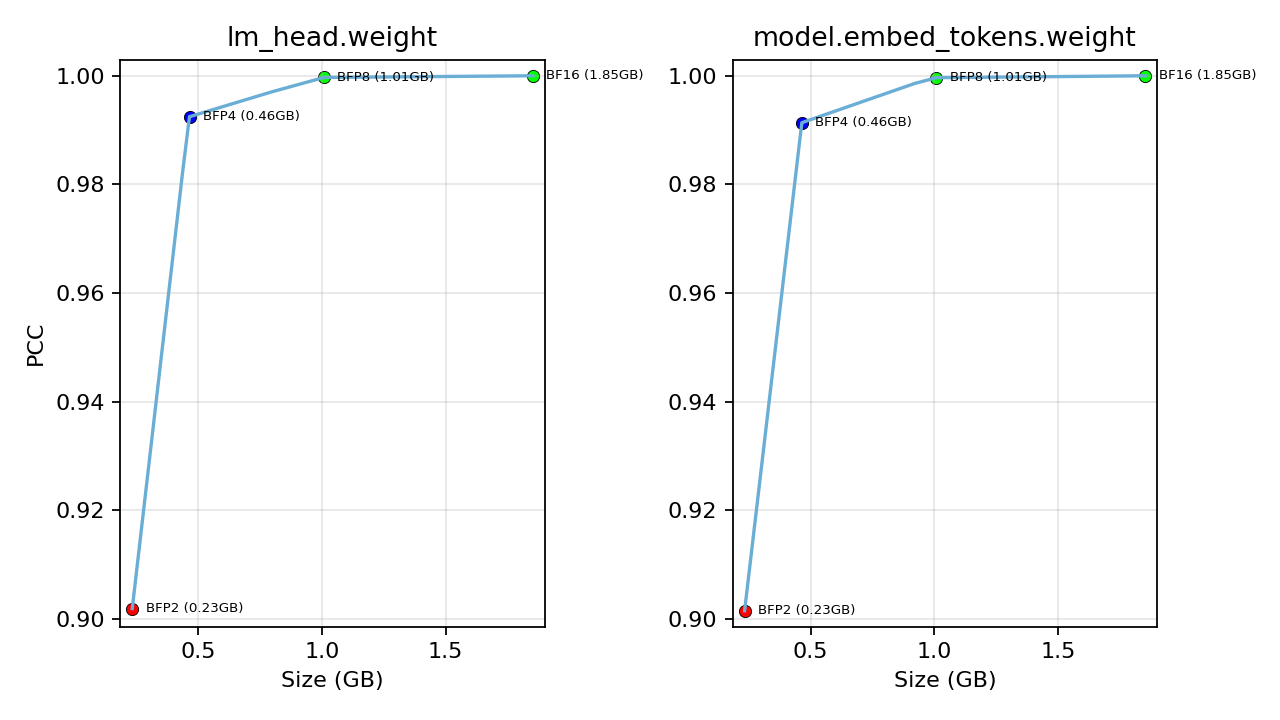

### 20260217-130032_attn

Layer overlay

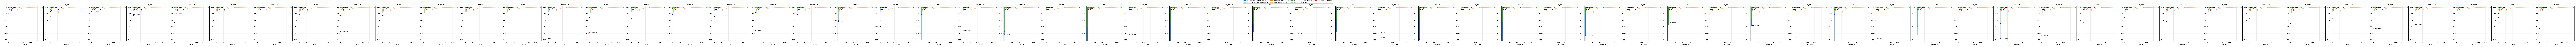

Weight overlay

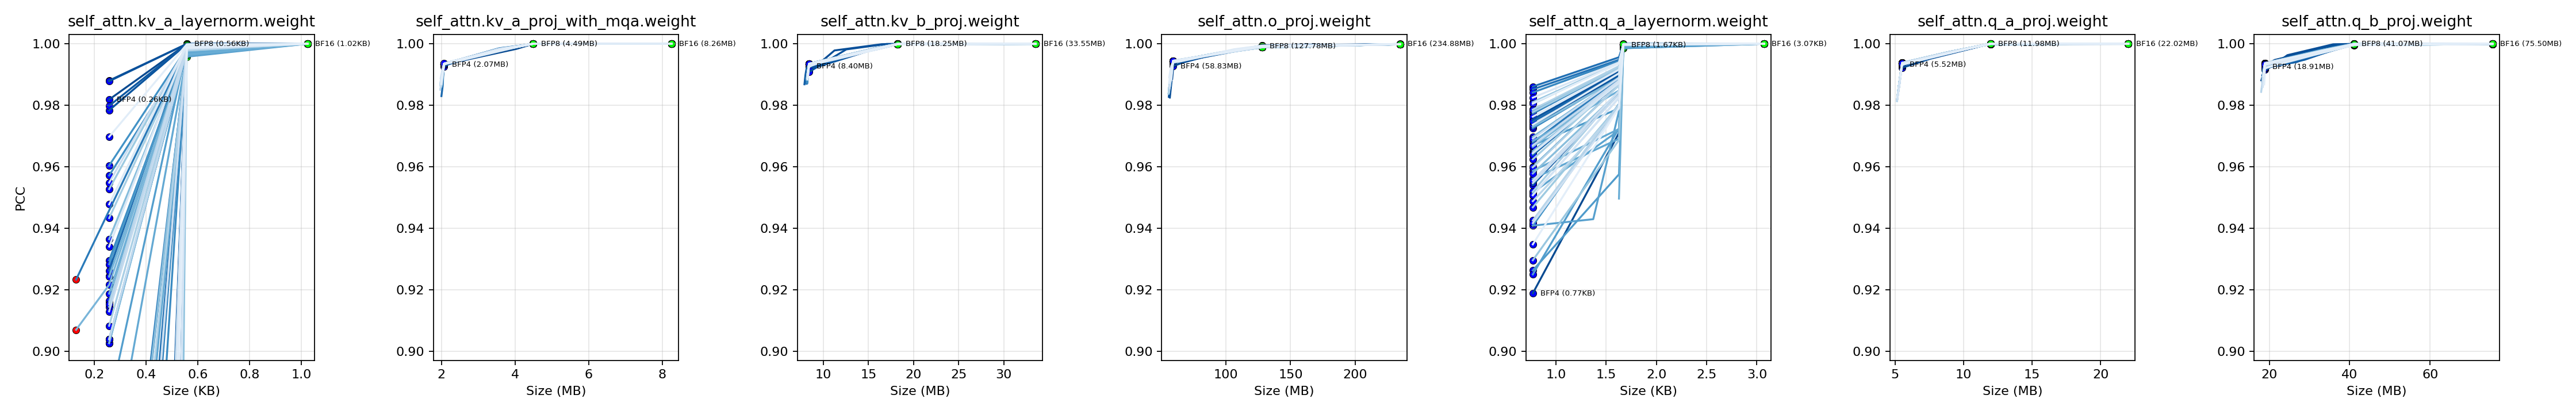

### 20260217-141059_mlp

Layer overlay

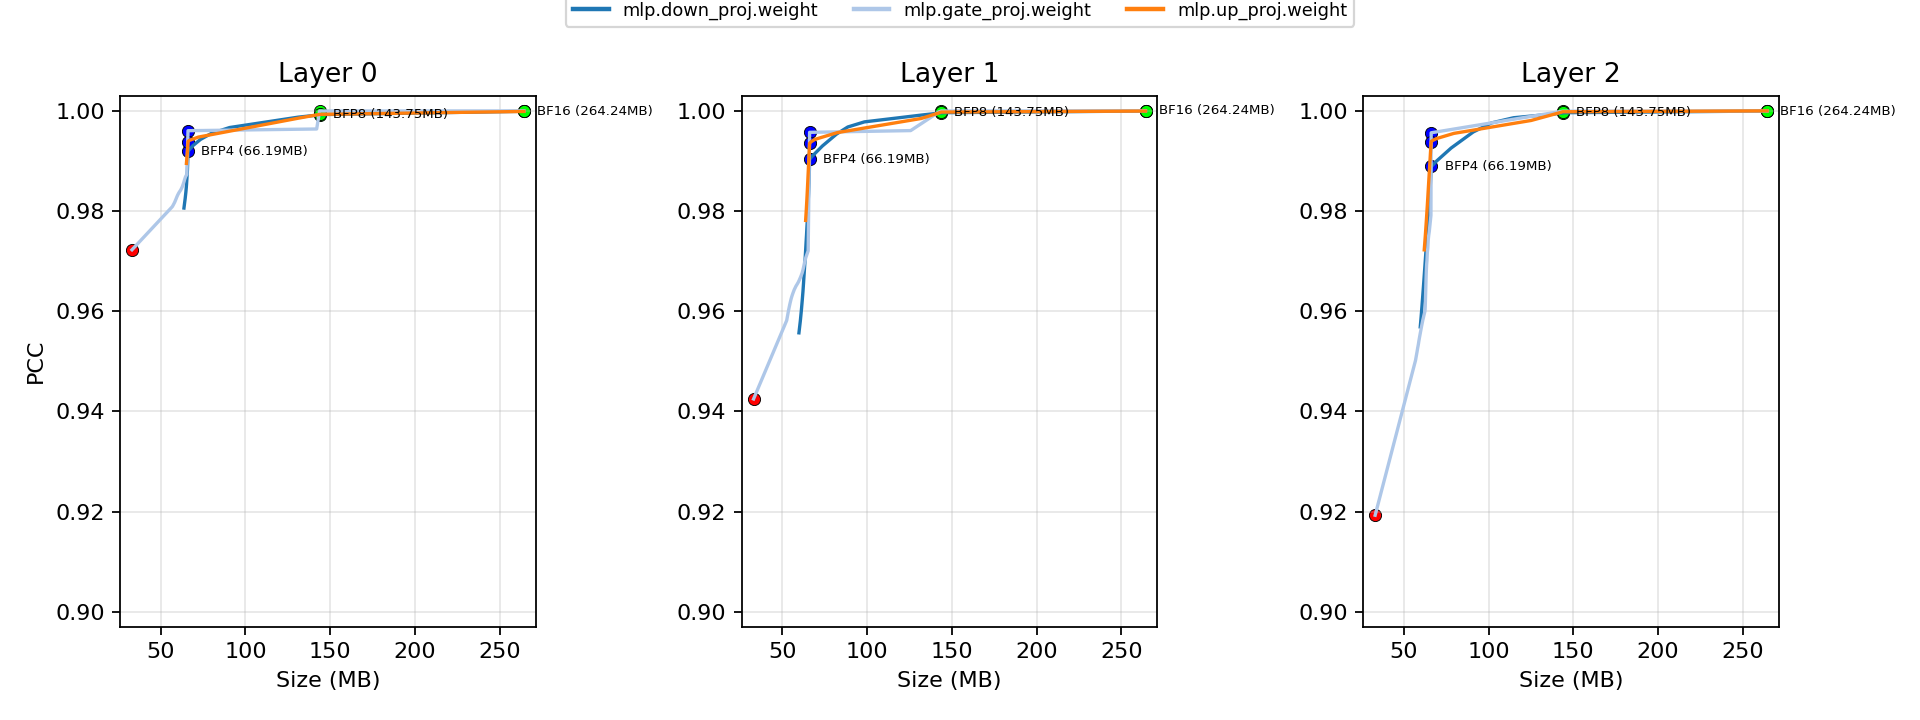

Weight overlay

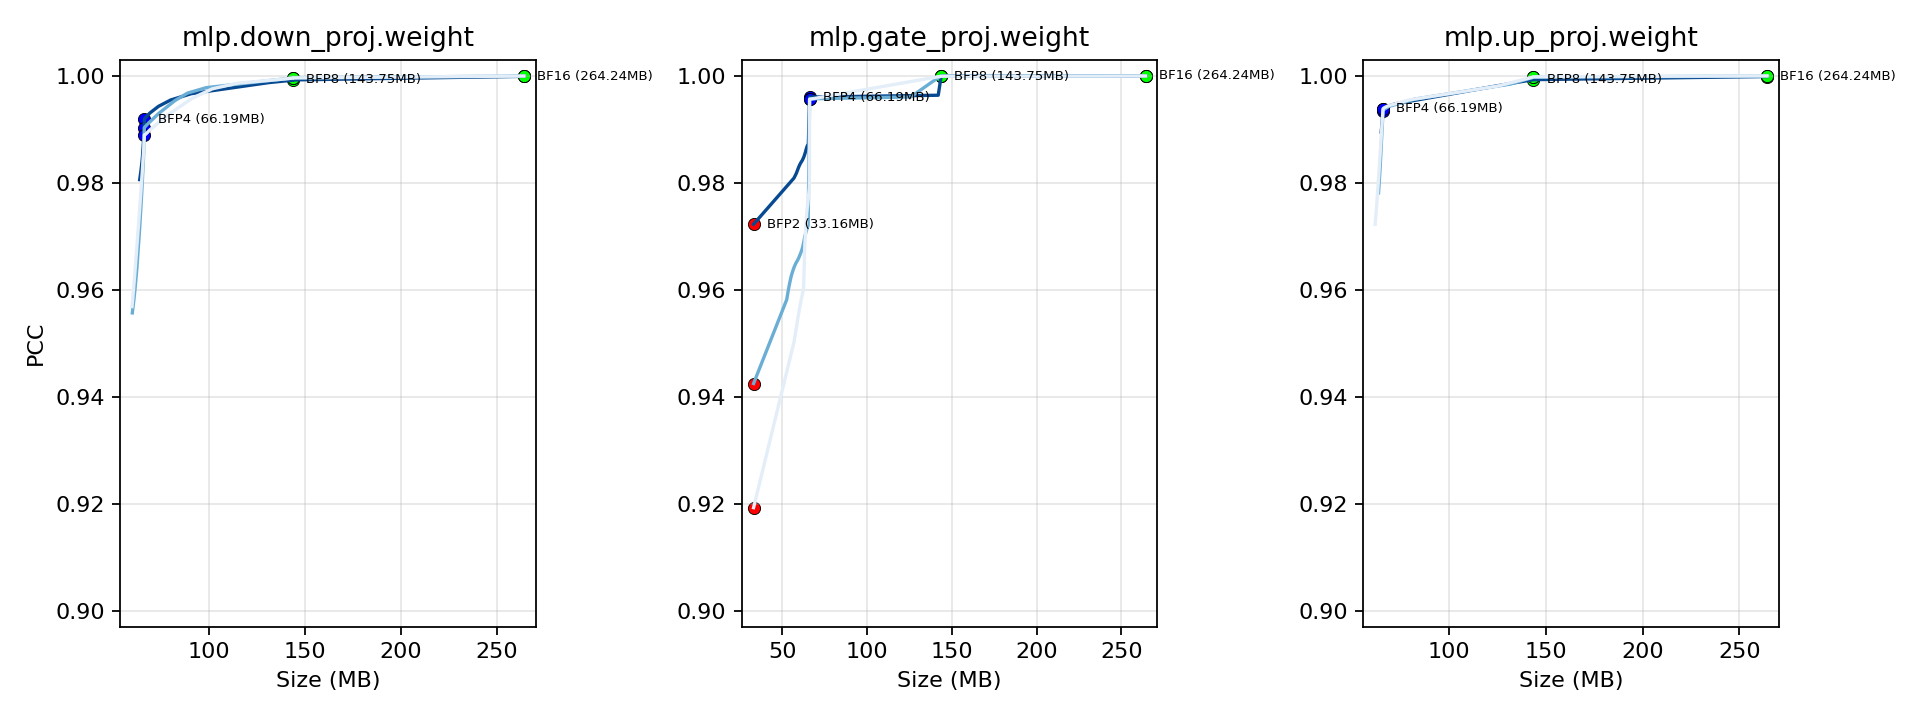

In [4]:
if not sweep_root.exists():
    raise FileNotFoundError(f"Sweep results folder not found: {sweep_root}")

run_dirs = sorted([p for p in sweep_root.iterdir() if p.is_dir()])
print(f"Found {len(run_dirs)} sweep run folder(s).")

for run_dir in run_dirs:
    display(Markdown(f"### {run_dir.name}"))
    layer_overlay = run_dir / "layer_overlays.png"
    weight_overlay = run_dir / "weight_overlays.png"

    if layer_overlay.exists():
        display(Markdown("Layer overlay"))
        display(Image(filename=str(layer_overlay)))
    else:
        display(Markdown("Layer overlay: not available in this run."))

    if weight_overlay.exists():
        display(Markdown("Weight overlay"))
        display(Image(filename=str(weight_overlay)))
    else:
        display(Markdown("Weight overlay: not available in this run."))


## Run WQ With Mixed-Tile-Threshold Config

Algorithm summary:
- For each 32x32 tile, choose the smallest format that satisfies the global threshold rule.
- Metric rule: `pcc >= threshold`, or `mae/atol <= threshold`.
- If no format passes for a tile, fallback is the highest-precision candidate format.
- Produces one `MIXED` result row plus tile assignment artifacts.

Run config:
- `algorithm`: `mixed-tile-threshold`
- `quantization_formats`: `bf16,bfp8,bfp4,bfp2,fp0`
- `params.metric`: `pcc`
- `params.threshold`: `0.94`

Config path: `results/deepseek-ai__DeepSeek-R1/mixed-tile-threshold/20260218-141937/compression_config.used.json`.

In [5]:
repo_id = "deepseek-ai/DeepSeek-R1"
tensor_name = "model.layers.0.mlp.down_proj.weight"
threshold_config = results_root / "mixed-tile-threshold" / "20260218-141937" / "compression_config.used.json"

cmd = [
    sys.executable,
    str(repo_root / "wq"),
    repo_id,
    tensor_name,
    "--compression-config",
    str(threshold_config),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True, cwd=str(repo_root))

threshold_run_dirs = sorted((results_root / "mixed-tile-threshold").glob("*"))
if not threshold_run_dirs:
    raise RuntimeError("No mixed-tile-threshold run directories found after execution.")
threshold_run_dir = threshold_run_dirs[-1]
print(f"Using run folder: {threshold_run_dir}")


Running: /Users/jrock/repos/quantization-plots/.venv/bin/python /Users/jrock/repos/quantization-plots/wq deepseek-ai/DeepSeek-R1 model.layers.0.mlp.down_proj.weight --compression-config /Users/jrock/repos/quantization-plots/results/deepseek-ai__DeepSeek-R1/mixed-tile-threshold/20260218-141937/compression_config.used.json


/Users/jrock/repos/quantization-plots/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


deepseek-ai/DeepSeek-R1 @main - 1 tensors
formats: bf16, bfp8, bfp4, bfp2, fp0
compression: none, mixed-tile-threshold
backend: emulation
config: /Users/jrock/repos/quantization-plots/results/deepseek-ai__DeepSeek-R1/mixed-tile-threshold/20260218-141937/compression_config.used.json

Hierarchy
  └── model
      └── layers
          └── 0
              └── mlp
                  └── down_proj
                      └── weight

cache: fp32 miss -> loading from HF cache/download


Evaluating:   0%|          | 0/6 [00:00<?, ?eval/s]

model.layers.0.mlp.down_proj.weight
  shape=(7168, 18432) min=-5.431e-01 mean=-2.944e-07 max=5.470e-01


Evaluating: 100%|██████████| 6/6 [01:08<00:00, 11.50s/eval]


  COMP                  FORMAT       PCC        MAE       ATOL  TIME(s)     GB
  none                  BF16   0.99990  2.886e-06  8.939e-04   24.362  0.264
  none                  BFP8   0.99924  1.819e-05  3.875e-03   24.362  0.144
  none                  BFP4   0.99193  2.906e-04  6.247e-02   24.362  0.066
  none                  BFP2   0.88343  1.106e-03  2.500e-01   24.362  0.033
  none                  FP0    0.00000  2.150e-03  5.470e-01   24.362  0.000

  COMP                  FORMAT       PCC        MAE       ATOL  TIME(s)     GB  BF16  BFP8    BFP4  BFP2       BYTES
  mixed-tile-threshold  MIXED   0.98922  2.975e-04  2.500e-01   36.754  0.066     0     0  128088   936  65,948,829

Using run folder: /Users/jrock/repos/quantization-plots/results/deepseek-ai__DeepSeek-R1/mixed-tile-threshold/20260224-100321


### Mixed-tile-threshold outputs: `20260224-100321`

model.layers.0.mlp.down_proj.weight
  shape=(7168, 18432) min=-5.431e-01 mean=-2.944e-07 max=5.470e-01
  COMP                  FORMAT       PCC        MAE       ATOL  TIME(s)     GB
  none                  BF16   0.99990  2.886e-06  8.939e-04   24.362  0.264
  none                  BFP8   0.99924  1.819e-05  3.875e-03   24.362  0.144
  none                  BFP4   0.99193  2.906e-04  6.247e-02   24.362  0.066
  none                  BFP2   0.88343  1.106e-03  2.500e-01   24.362  0.033
  none                  FP0    0.00000  2.150e-03  5.470e-01   24.362  0.000

  COMP                  FORMAT       PCC        MAE       ATOL  TIME(s)     GB  BF16  BFP8    BFP4  BFP2       BYTES
  mixed-tile-threshold  MIXED   0.98922  2.975e-04  2.500e-01   36.754  0.066     0     0  128088   936  65,948,829




Size vs accuracy

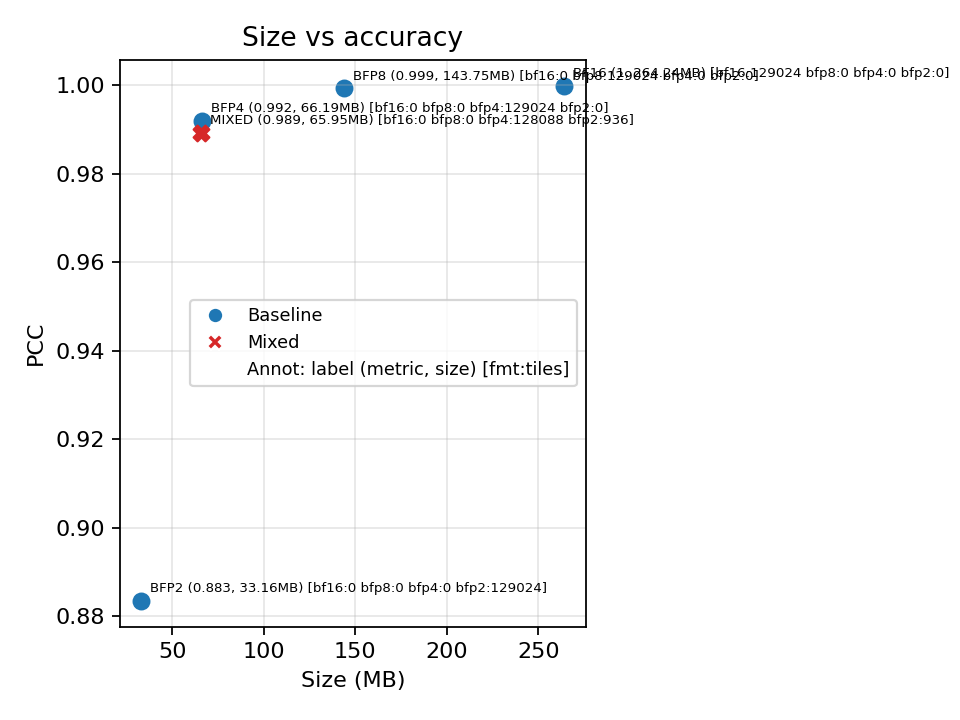

Tile assignment

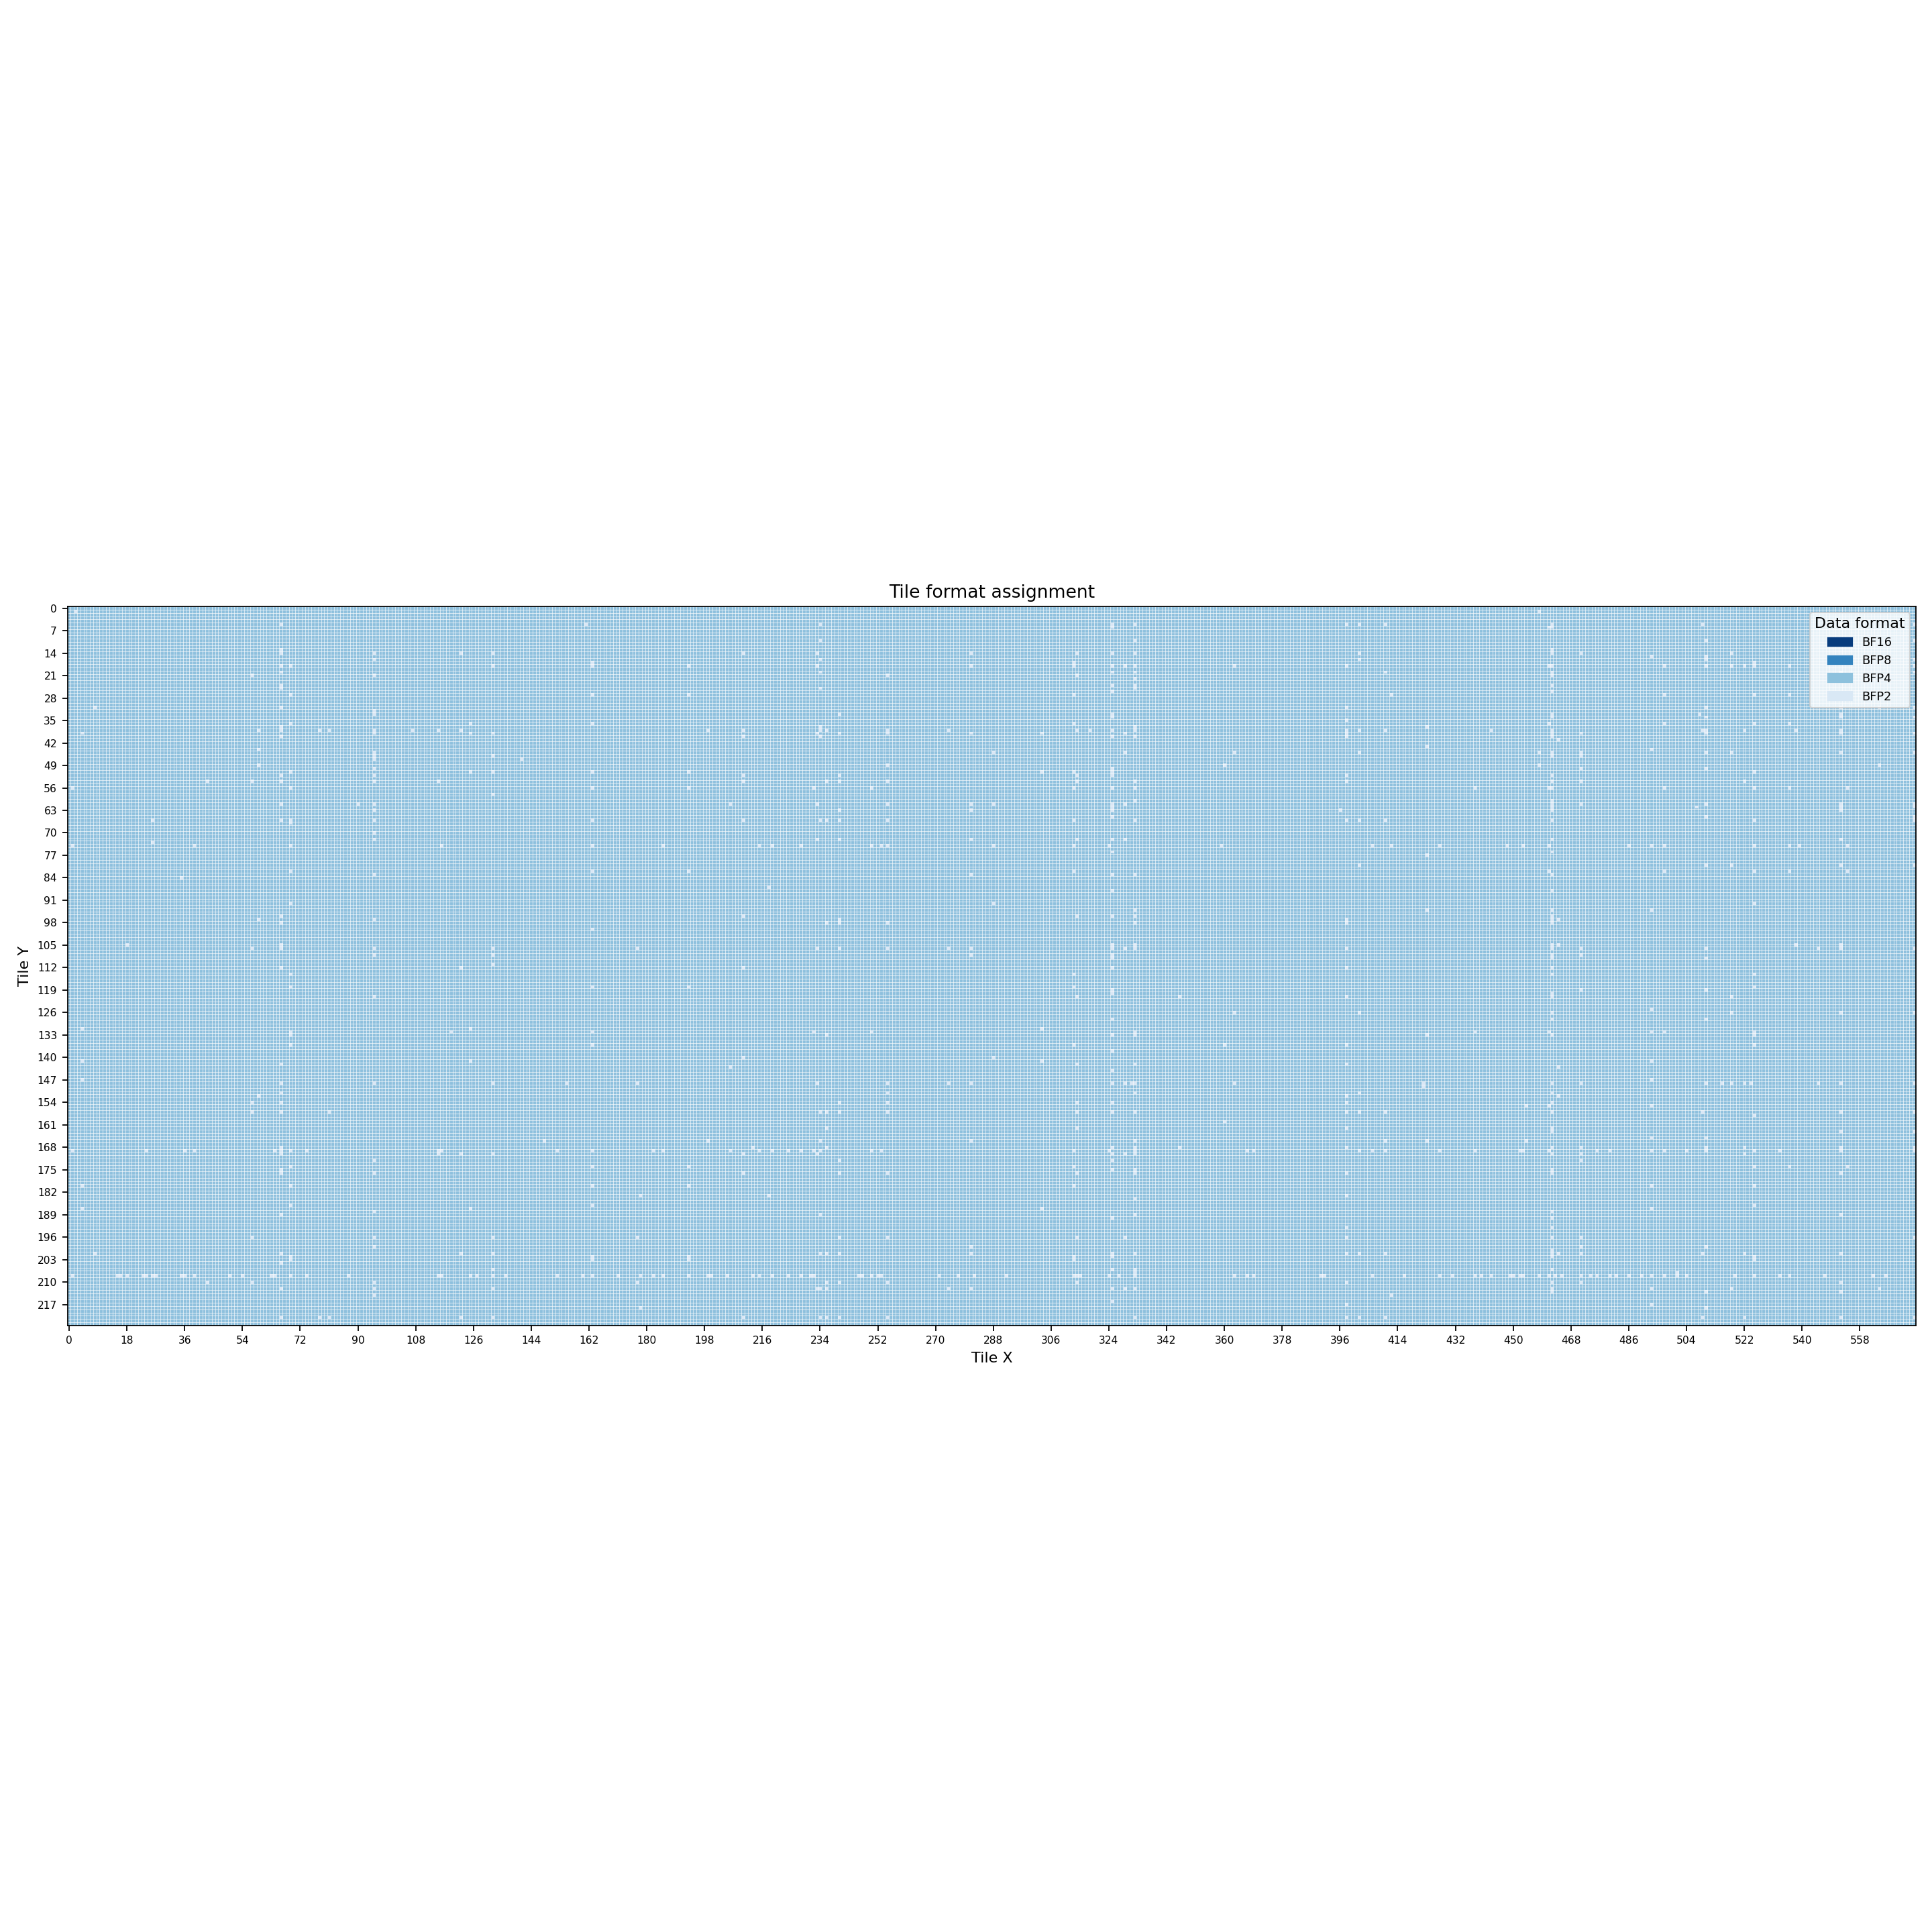

In [6]:
display(Markdown(f"### Mixed-tile-threshold outputs: `{threshold_run_dir.name}`"))

table_path = threshold_run_dir / "table.txt"
if table_path.exists():
    print(table_path.read_text(encoding="utf-8"))
else:
    print("table.txt not found")

threshold_plot_dir = threshold_run_dir / "mixed_tile_threshold" / tensor_name
threshold_assignment = next(threshold_plot_dir.glob("*_assignment.png"), None)
threshold_size_plot = threshold_plot_dir / "size_vs_accuracy.png"

if threshold_size_plot.exists():
    display(Markdown("Size vs accuracy"))
    display(Image(filename=str(threshold_size_plot)))
else:
    display(Markdown("Size vs accuracy plot not found."))

if threshold_assignment is not None:
    display(Markdown("Tile assignment"))
    display(Image(filename=str(threshold_assignment)))
else:
    display(Markdown("Tile assignment plot not found."))


## Run WQ With Mixed-Tile-Greedy Config

Algorithm summary:
- Start every 32x32 tile in a base format (first format in the candidate list).
- Iterate candidate formats and tiles (randomized order controlled by seed).
- Apply a candidate change only if the resulting global metric still satisfies threshold.
- Produces one final `MIXED` assignment and size-vs-accuracy/assignment plots.

Run config:
- `algorithm`: `mixed-tile-greedy`
- `quantization_formats`: `bf16,bfp8,bfp4,bfp2,fp0`
- `params.metric`: `pcc`
- `params.threshold`: `0.999`
- `seed`: value resolved in config (`seed_source` recorded in output)

Config path: `results/deepseek-ai__DeepSeek-R1/mixed-tile-greedy/20260218-150721/compression_config.used.json`.

In [7]:
greedy_config = results_root / "mixed-tile-greedy" / "20260218-150721" / "compression_config.used.json"

cmd = [
    sys.executable,
    str(repo_root / "wq"),
    repo_id,
    tensor_name,
    "--compression-config",
    str(greedy_config),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True, cwd=str(repo_root))

greedy_run_dirs = sorted((results_root / "mixed-tile-greedy").glob("*"))
if not greedy_run_dirs:
    raise RuntimeError("No mixed-tile-greedy run directories found after execution.")
greedy_run_dir = greedy_run_dirs[-1]
print(f"Using run folder: {greedy_run_dir}")


Running: /Users/jrock/repos/quantization-plots/.venv/bin/python /Users/jrock/repos/quantization-plots/wq deepseek-ai/DeepSeek-R1 model.layers.0.mlp.down_proj.weight --compression-config /Users/jrock/repos/quantization-plots/results/deepseek-ai__DeepSeek-R1/mixed-tile-greedy/20260218-150721/compression_config.used.json


/Users/jrock/repos/quantization-plots/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


deepseek-ai/DeepSeek-R1 @main - 1 tensors
formats: bf16, bfp8, bfp4, bfp2, fp0
compression: none, mixed-tile-greedy
backend: emulation
config: /Users/jrock/repos/quantization-plots/results/deepseek-ai__DeepSeek-R1/mixed-tile-greedy/20260218-150721/compression_config.used.json

Hierarchy
  └── model
      └── layers
          └── 0
              └── mlp
                  └── down_proj
                      └── weight

cache: fp32 hit (data/hf-cache/tensor-fp32/deepseek-ai__DeepSeek-R1--main--c9713baf5d94/model.layers.0.mlp.down_proj.weight--19158e4c223e.npy)


Evaluating:   0%|          | 0/6 [00:00<?, ?eval/s]

model.layers.0.mlp.down_proj.weight
  shape=(7168, 18432) min=-5.431e-01 mean=-2.944e-07 max=5.470e-01


Evaluating: 100%|██████████| 6/6 [00:40<00:00,  6.75s/eval]


  COMP               FORMAT       PCC        MAE       ATOL  TIME(s)     GB
  none               BF16   0.99990  2.886e-06  8.939e-04    1.119  0.264
  none               BFP8   0.99924  1.819e-05  3.875e-03    1.119  0.144
  none               BFP4   0.99193  2.906e-04  6.247e-02    1.119  0.066
  none               BFP2   0.88343  1.106e-03  2.500e-01    1.119  0.033
  none               FP0    0.00000  2.150e-03  5.470e-01    1.119  0.000

  COMP               FORMAT       PCC        MAE       ATOL  TIME(s)     GB  BF16    BFP8   BFP4  BFP2        BYTES
  mixed-tile-greedy  MIXED   0.99846  4.735e-05  6.247e-02   30.881  0.135     0  115209  13815     0  135,442,732

Using run folder: /Users/jrock/repos/quantization-plots/results/deepseek-ai__DeepSeek-R1/mixed-tile-greedy/20260224-101742


### Mixed-tile-greedy outputs: `20260224-101742`

model.layers.0.mlp.down_proj.weight
  shape=(7168, 18432) min=-5.431e-01 mean=-2.944e-07 max=5.470e-01
  COMP               FORMAT       PCC        MAE       ATOL  TIME(s)     GB
  none               BF16   0.99990  2.886e-06  8.939e-04    1.119  0.264
  none               BFP8   0.99924  1.819e-05  3.875e-03    1.119  0.144
  none               BFP4   0.99193  2.906e-04  6.247e-02    1.119  0.066
  none               BFP2   0.88343  1.106e-03  2.500e-01    1.119  0.033
  none               FP0    0.00000  2.150e-03  5.470e-01    1.119  0.000

  COMP               FORMAT       PCC        MAE       ATOL  TIME(s)     GB  BF16    BFP8   BFP4  BFP2        BYTES
  mixed-tile-greedy  MIXED   0.99846  4.735e-05  6.247e-02   30.881  0.135     0  115209  13815     0  135,442,732




Size vs accuracy

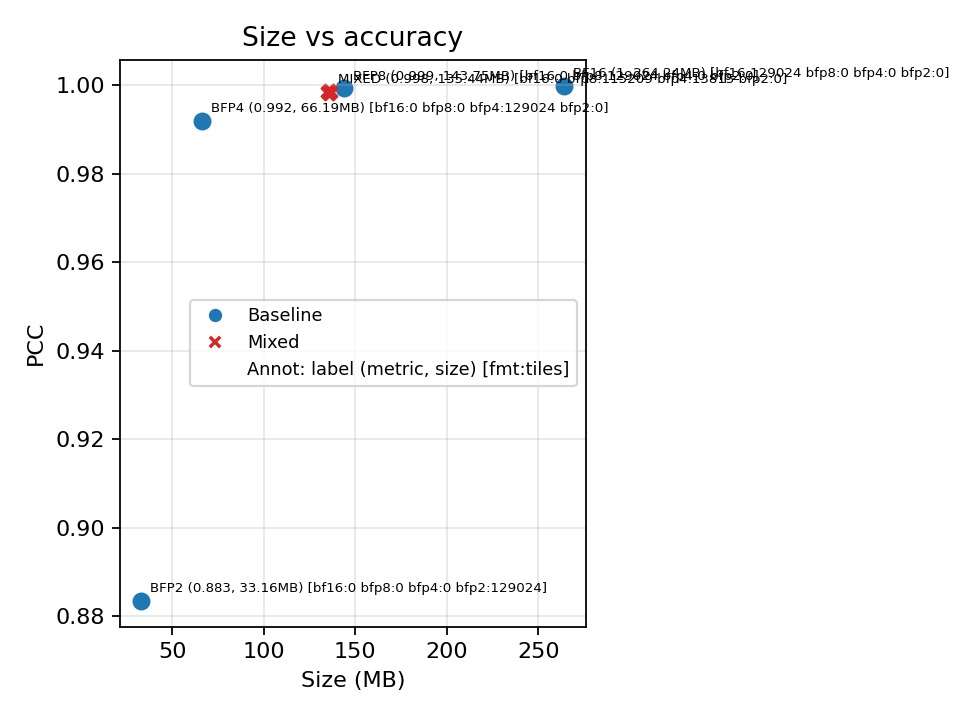

Tile assignment

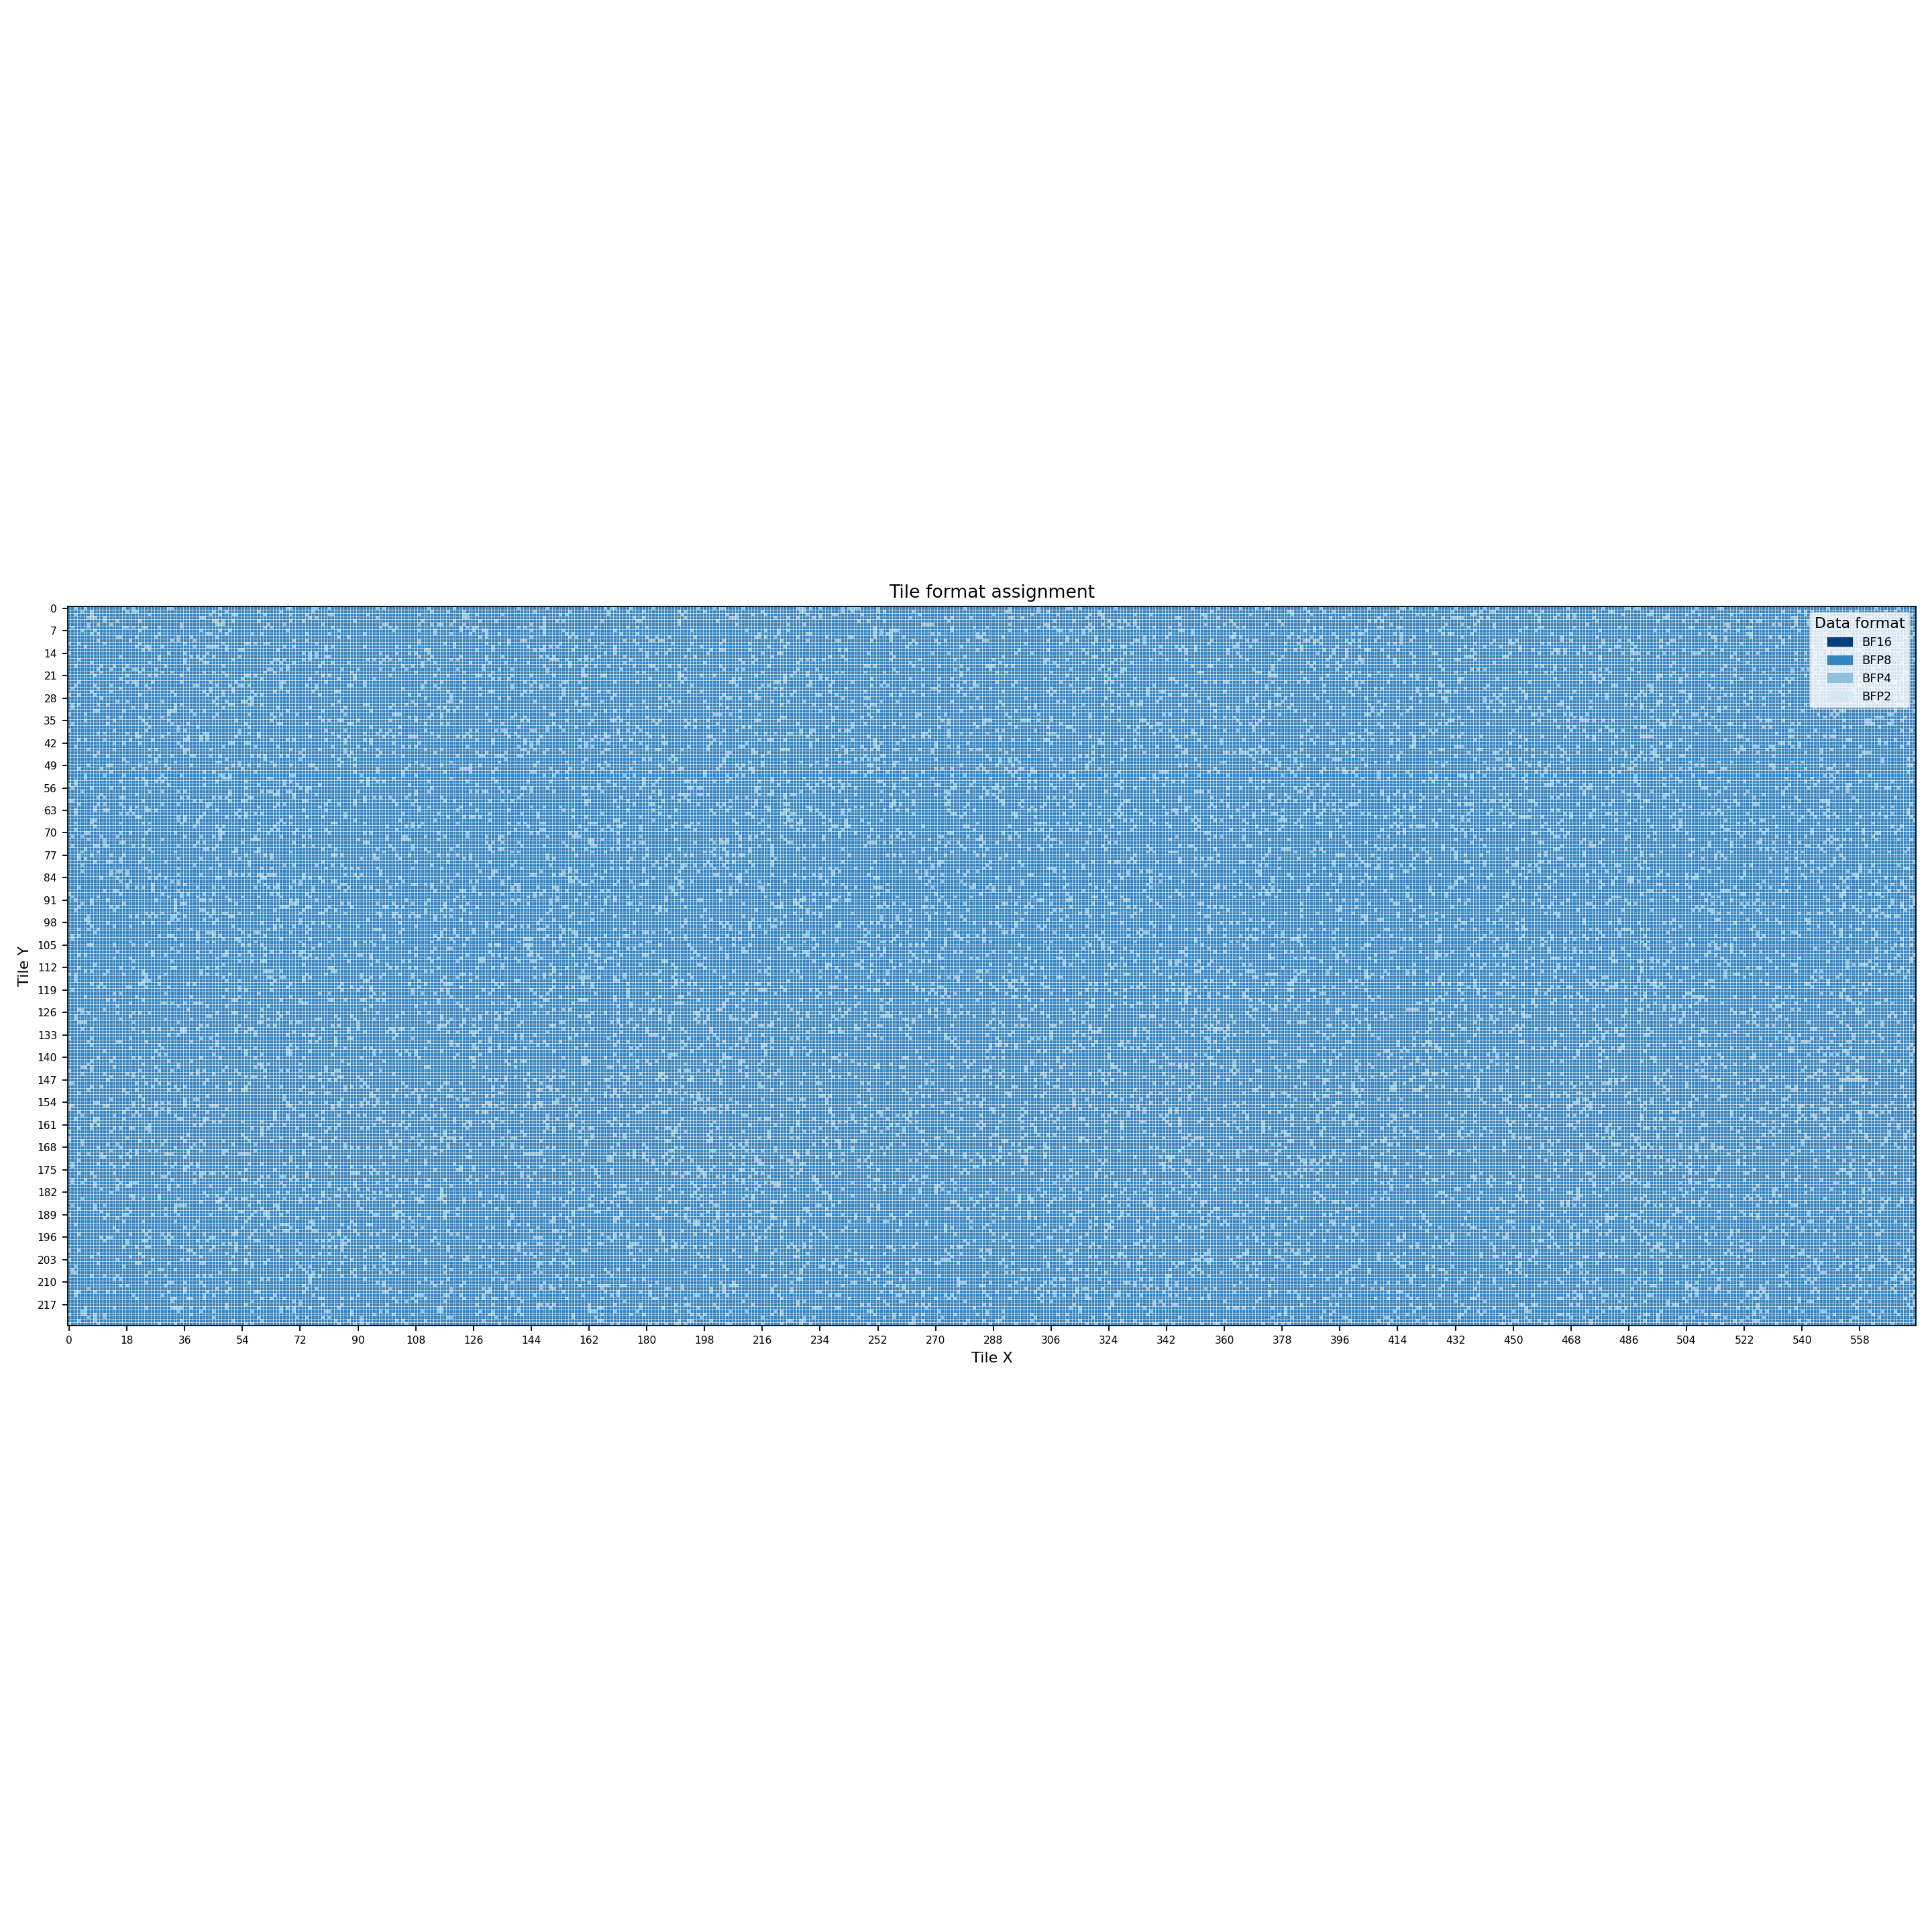

In [8]:
display(Markdown(f"### Mixed-tile-greedy outputs: `{greedy_run_dir.name}`"))

table_path = greedy_run_dir / "table.txt"
if table_path.exists():
    print(table_path.read_text(encoding="utf-8"))
else:
    print("table.txt not found")

greedy_plot_dir = greedy_run_dir / "mixed_tile_greedy" / tensor_name
greedy_assignment = next(greedy_plot_dir.glob("*_assignment.png"), None)
greedy_size_plot = greedy_plot_dir / "size_vs_accuracy.png"

if greedy_size_plot.exists():
    display(Markdown("Size vs accuracy"))
    display(Image(filename=str(greedy_size_plot)))
else:
    display(Markdown("Size vs accuracy plot not found."))

if greedy_assignment is not None:
    display(Markdown("Tile assignment"))
    display(Image(filename=str(greedy_assignment)))
else:
    display(Markdown("Tile assignment plot not found."))
